# Source Amplification / Noise Reduction

This notebook walks through the main tasks of the assignment, and explains acquired results as necessary.

## Algorithms

### Dependencies

These are the packages I used throughout the notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import csv
import os
import time as tick
from scipy.io import loadmat
from scipy.signal import freqz

### Utility

In [2]:
PLOT_DIR = "plots"

CSV_FILENAME = "all_results.csv"

if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

def plot_and_save(sig_true, sig_pred, figname, title="Comparison"):
    """
    Plots the true signal vs predicted, saves to figname.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(sig_true, label="Actual Output", alpha=0.7)
    plt.plot(sig_pred, label="Predicted Output", alpha=0.7)
    plt.title(title)
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, figname), dpi=150)

def plot_comparison(sig_input, sig_noisy, sig_pred, title="", max_pts=300):
    """
    Plots three signals in a single figure:
      1) Input signal
      2) Noisy/observed output
      3) Predicted output

    max_pts: number of samples to show (for clarity).
    """
    length = min(max_pts, len(sig_input), len(sig_noisy), len(sig_pred))
    plt.figure(figsize=(8,4))
    plt.plot(sig_input[:length], label="Input Signal", alpha=0.7)
    plt.plot(sig_noisy[:length], label="Noisy Output", alpha=0.7)
    plt.plot(sig_pred[:length], label="Predicted Output", alpha=0.7)
    plt.title(title)
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_with_variance(time, true_signal, pred_mean, pred_std,
                       title, xlabel="Sample index", ylabel="Signal",
                       label_true="True Signal", label_pred="Predicted Signal", 
                       position = 'last', max_pts=500):
    '''
    A plotting function that plots the true signal alongside the mean
    prediction with a shaded region indicating ± one standard deviation.
    '''
    if position == 'first':
        plt.figure(figsize=(10, 6))
        length = min(max_pts, len(time), len(true_signal), len(pred_mean), len(pred_std))
        plt.plot(time[:length], true_signal[:length], label=label_true, color='blue', linewidth=2)
        plt.plot(time[:length], pred_mean[:length], label=label_pred, color='red', linestyle='--', linewidth=2)
        #plt.fill_between(time[:length], pred_mean[:length] - pred_std[:length], pred_mean[:length] + pred_std[:length],color='red', alpha=0.3, label="Prediction ±1 STD")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.show()
    elif position == 'last':
        plt.figure(figsize=(10, 6))
        length = min(max_pts, len(time), len(true_signal), len(pred_mean), len(pred_std))
        plt.plot(time[-length:], true_signal[-length:], label=label_true, color='blue', linewidth=2)
        plt.plot(time[-length:], pred_mean[-length:], label=label_pred, color='red', linestyle='--', linewidth=2)
        #plt.fill_between(time[:length], pred_mean[:length] - pred_std[:length], pred_mean[:length] + pred_std[:length],color='red', alpha=0.3, label="Prediction ±1 STD")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.show()
    else:
        raise ValueError("position must be either 'first' or 'last'")

### Filter Measurements

In [3]:
def compute_weighted_snr(w_true, w_est):
    """
    Weighted SNR = 10 * log10( (w_true^T w_true) / ( (w_true - w_est)^T (w_true - w_est) ) ).
    """
    num = np.dot(w_true, w_true)
    den = np.dot(w_true - w_est, w_true - w_est)
    if den < 1e-15:
        return 999.0
    return 10.0 * np.log10(num / den)

### Normalized Least Mean Squares Calculations

In [4]:
def apply_nlms_filter(x_in, w_lms_k, y_noisy, mu=None, eps=None):
    """
    Applies the NLMS filter to the input signal x_in.

    x_in: input signal (M x 1)
    w_lms_k: filter weights at time k (M x 1)
    y_noisy: noisy output signal (scalar)
    mu: learning rate
    eps: regularization parameter
    """
    if mu is None:
        raise ValueError("mu must be specified.")
    if eps is None:
        raise ValueError("eps must be specified.")
    
    y_hat = np.dot(w_lms_k, x_in)
    e = y_noisy - y_hat
    x_pow  = np.dot(x_in, x_in)
    mu_eff = mu / (x_pow + eps)
    w_lms_k1 = w_lms_k + mu_eff * e * x_in

    return y_hat, w_lms_k1, mu_eff, e

def nlms_filter_full(x_in, d, M, mu, eps=1e-15):
    """
    Basic NLMS for system ID. Returns final filter after N updates.
    """
    N = len(x_in)
    x_eff = np.pad(x_in, (M-1, 0), mode='constant')
    y_hat = np.zeros(N)
    w_hist = np.zeros((N, M))
    mu_eff_hist = np.zeros(N)
    e_hist = np.zeros(N)
    for n in range(N):
        x_vec = x_eff[n:n+M]
        y_hat[n], w_hist[n], mu_eff_hist[n], e_hist[n] = apply_nlms_filter(x_vec, w_hist[n-1], d[n], mu, eps)
        
    return w_hist, y_hat, mu_eff_hist, e_hist

def apply_nlms_filter_2(x0_in, x1_in, w_k, g_k, mu=None, lambda_=None, eps=None):
    """
    Applies the NLMS filter to the input signal x0_in and x1_in.

    x0_in: input signal (M x 1)
    x1_in: input signal (M x 1)
    w_k: filter weights at time k (M x 1)
    g_k: gain at time k (scalar)
    mu: learning rate
    lambda_: weight regularization parameter
    eps: power regularization parameter
    """
    if mu is None:
        raise ValueError("mu must be specified.")
    if eps is None:
        raise ValueError("eps must be specified.")
    
    y0_hat_k = g_k * np.dot(w_k, x0_in)
    y1_hat_k = g_k * np.dot(w_k, x1_in)
    e_k = y1_hat_k - y0_hat_k
    x_pow  = np.dot(x0_in, x0_in)
    mu_eff = mu / (x_pow + eps)
    w_k1 = w_k*(1 - mu_eff * lambda_) + e_k * mu_eff * g_k * (x1_in - x0_in)
    w_k1 = w_k1 / np.linalg.norm(w_k1)
    g_k1 = g_k + mu_eff * e_k**2 / g_k

    return y0_hat_k, y1_hat_k, w_k1, g_k1, mu_eff, e_k

def nlms_filter_full_2(x0_in, x1_in, M, mu, lambda_, eps=1e-15):
    """
    Basic NLMS for system ID. Returns final filter after N updates.
    """
    N = len(x0_in)
    x0_eff = np.pad(x0_in, (M-1, 0), mode='constant')
    x1_eff = np.pad(x1_in, (M-1, 0), mode='constant')
    y0_hat = np.zeros(N)
    y1_hat = np.zeros(N)
    w_hist = np.zeros((N, M))
    g_hist = np.zeros(N)
    mu_eff_hist = np.zeros(N)
    e_hist = np.zeros(N)
    for n in range(N):
        x0_vec = x0_eff[n:n+M]
        x1_vec = x1_eff[n:n+M]
        y0_hat[n], y1_hat[n], w_hist[n], g_hist[n], mu_eff_hist[n], e_hist[n] = apply_nlms_filter_2(x0_vec, x1_vec, w_hist[n-1], g_hist[n-1], mu, lambda_, eps)
        
    return w_hist, g_hist, y0_hat, y1_hat, mu_eff_hist, e_hist

### Variable Step Size Affine Projection Algorithm Filter

In [5]:
def apply_vss_apa_filter(X, d_vec, w, mu, delta):
    """
    Applies one iteration of the VSS-APA filter.
    
    Parameters:
      X: np.ndarray of shape (M, P) - input data matrix.
      d_vec: np.ndarray of shape (P,) - desired output vector corresponding to the columns of X.
      w: np.ndarray of shape (M,) - current filter weight vector.
      mu: float - current step size.
      delta: float - regularization parameter.
      
    Returns:
      w_new: updated weight vector (M,)
      y_vec: output vector computed as X.T @ w (P,)
      e: error vector (P,)
    """
    # Compute the output vector for the block
    y_vec = X.T @ w  # shape: (P,)
    e = d_vec - y_vec  # error vector

    # Compute the inversion term: (X.T @ X + delta * I)
    A = X.T @ X + delta * np.eye(X.shape[1])
    A_inv = np.linalg.inv(A)

    # Update the weight vector according to the APA rule
    w_new = w + mu * (X @ (A_inv @ e))
    return w_new, y_vec, e

def vss_apa_filter_full(x, d, M, P, mu0, delta, mu_min, mu_max, rho, eta, 
                        alpha=0.9, beta=0.8, w_init=None, mu_init=None, num_predictions=None):
    """
    Apply the Variable Step-Size Affine Projection Algorithm (VSS-APA) to an entire input signal.
    
    Parameters:
      x: 1D NumPy array of input samples.
      d: 1D NumPy array of desired outputs.
      M: Filter order (length of the adaptive filter).
      P: Projection order (number of past input vectors used for the update).
      mu0: Initial step size.
      delta: Regularization parameter.
      mu_min: Minimum allowed step size.
      mu_max: Maximum allowed step size.
      rho: Adaptation rate for the step size.
      eta: Target error energy threshold for step size adaptation.
      alpha: Exponential smoothing factor for error energy (default 0.9).
      beta: Momentum factor for step-size adaptation (default 0.8).
      w_init: Optional initial weight vector.
      mu_init: Optional initial step size.
      num_predictions: Optional integer specifying how many predictions to output.
      
    Returns:
      predictions: 1D NumPy array of predictions corresponding to each iteration.
      weight_history: 2D NumPy array where each row is the filter weight vector at each iteration.
      mu_history: List of step sizes (mu) over iterations.
      error_history: 2D NumPy array of error vectors for each iteration.
    """
    start_index = M + P - 1  # Ensure enough samples for forming a full block

    # Determine number of iterations
    if num_predictions is None:
        num_iterations = len(x) - start_index
    else:
        num_iterations = num_predictions

    predictions = []
    weight_history = []
    mu_history = []
    error_history = []
    
    # Initialize the filter weights and step size
    w = w_init.copy() if w_init is not None else np.zeros(M)
    mu = mu_init if mu_init is not None else mu0
    error_energy_prev = eta  # Initialize with target error threshold
    
    # Iterate for the specified number of predictions
    for k in range(start_index, start_index + num_iterations):
        # Construct the input matrix X (shape: M × P)
        X = np.zeros((M, P))
        for p in range(P):
            idx_end = k - p
            idx_start = idx_end - M + 1
            X[:, p] = x[idx_start: idx_end + 1]
        
        # Construct the desired output vector for this block
        d_vec = np.array([d[k - p] for p in range(P)])
        
        # Apply one iteration of the VSS-APA update
        w, y_vec, e = apply_vss_apa_filter(X, d_vec, w, mu, delta)
        
        # Store the prediction corresponding to the most recent sample (d[k])
        predictions.append(y_vec[0])
        weight_history.append(w.copy())
        error_history.append(e.copy())
        mu_history.append(mu)
        
        # Compute the smoothed error energy using exponential smoothing
        error_energy = np.linalg.norm(e)**2
        error_energy_smoothed = alpha * error_energy_prev + (1 - alpha) * error_energy

        # Compute RMS-based normalized update
        rms_error = np.sqrt(np.mean(error_energy**2) + 1e-6)  # Prevents division by zero
        mu_update = rho * (error_energy_smoothed - eta) / (rms_error + 1e-6)

        # Apply momentum term for smoother step-size updates
        mu = beta * mu + (1 - beta) * mu_update

        # Ensure mu remains within the specified bounds
        mu = np.clip(mu, mu_min, mu_max)

        # Store previous error energy for smoothing
        error_energy_prev = error_energy_smoothed
    
    return (np.array(predictions), np.array(weight_history), mu_history, np.array(error_history))


### Load Data & Constants

In [6]:
# Load your input signals (update if needed)
# Load signals using scipy for mat files
data = loadmat('project1.mat')

num_trials = 1
fs = 21000
d = data['primary'][0]
x = data['reference'][0]
N = len(x)

# Example parameters

model_orders = [16, 64, 256]
window_sizes = [100, 500, 5000]
mu_candidates = [2**-12, 2**-11.5, 2**-11, 2**-10.5, 2**-10, 2**-9.5, 2**-9, 2**-8.5, 
                 2**-8, 2**-7.5, 2**-7, 2**-6.5, 2**-6, 2**-5.5, 2**-5, 2**-4.5, 
                 2**-4, 2**-3.5, 2**-3, 2**-2.5, 2**-2, 2**-1.5, 2**-1, 2**-0.5, 2**0]
alpha_candidates = [0.999, 0.989, 0.9999, 0.9997, 0.9989, 0.99999, 0.99997, 0.99989, 0.999999, 0.999997, 
                    0.999989, 0.9999999, 0.9999997, 0.9999989, 0.99999999, 0.99999997, 0.99999989, 0.999999999999999]
rho_candidates   = [1e-4, 5e-4, 1e-3, 5e-3]

# VSS-APA parameters:
P      = 3         # Projection order
mu0    = 0.1       # Initial step size
delta  = 1e-3      # Regularization constant
mu_min = 0.001     # Minimum allowed step size
mu_max = 1.0       # Maximum allowed step size
eta    = 0.001     # Target error energy

## Normalized Least Mean Squares Filter

### General Treatment

Consider the following:

$ x_1 = F_1(N) $

$ x_2 = F_2(S + N) $

$ y_i = G(x_i) = w^T x_i$


### Treatment 1

$ d = x_2 $

$ e = d - y_1 = F_2(S + N) - G(F_1(N)) $

Ideally, we want $ e \approx S$

If we assume $G(*) \approx F_2(F_1^{-1}(*))$, and that $F_2(*)$ is linear, then

$ e \approx F_2(S + N) - F_2(F_1^{-1}(F_1(N))) = F_2(S + N) - F_2(N) = F_2(S) $

If we assume that $F_2(*) \approx * $, then $e \approx S$

#### 2-Tap Filter Inspection

##### Experiment Helper Functions

In [7]:
# Experiment 1: Performance Surface Contours for a 2-tap filter.
def experiment_performance_surface_2tap(x, d, grid_span=0.5, grid_points=100):
    """
    Computes and plots the performance surface contours (mean squared error)
    as a function of the two filter weights. A least-squares solution is used
    to center the grid.
    
    Parameters:
      x          : 1D numpy array, input signal.
      d          : 1D numpy array, desired output.
      grid_span  : float, half-width of the grid around the optimal weight.
      grid_points: int, number of grid points per axis.
    """
    M = 2
    N = len(x)
    # Create the effective input matrix as in nlms_filter_full (with padding).
    x_eff = np.pad(x, (M-1, 0), mode='constant')
    X = np.array([x_eff[i:i+M] for i in range(N)])
    
    # Compute the optimal (Wiener) solution using least-squares.
    w_opt, _, _, _ = np.linalg.lstsq(X, d, rcond=None)
    
    # Create a grid centered around the optimal weights.
    w0_range = np.linspace(w_opt[0] - grid_span, w_opt[0] + grid_span, grid_points)
    w1_range = np.linspace(w_opt[1] - grid_span, w_opt[1] + grid_span, grid_points)
    W0, W1 = np.meshgrid(w0_range, w1_range)
    cost = np.zeros_like(W0)
    
    # Compute MSE cost at each grid point.
    for i in range(W0.shape[0]):
        for j in range(W0.shape[1]):
            w_candidate = np.array([W0[i, j], W1[i, j]])
            y_candidate = np.dot(X, w_candidate)
            error = d - y_candidate
            cost[i, j] = np.mean(error**2)
    
    # Plot the contours.
    plt.figure(figsize=(8, 6))
    contour_set = plt.contour(W0, W1, cost, levels=30)
    plt.clabel(contour_set, inline=True, fontsize=9)
    plt.plot(w_opt[0], w_opt[1], 'ro', label="Optimal weights")
    plt.xlabel("Weight 0")
    plt.ylabel("Weight 1")
    plt.title("Performance Surface Contours for 2-tap NLMS Filter")
    plt.legend()
    plt.show()

# Experiment 2: Plot Weight Tracks.
def experiment_weight_tracks_2tap(x, d, mu):
    """
    Runs the NLMS filter with a 2-tap filter and plots the evolution
    (tracks) of each weight over iterations.
    
    Parameters:
      x  : 1D numpy array, input signal.
      d  : 1D numpy array, desired signal.
      mu : Learning rate for NLMS.
    """
    M = 2
    # Run NLMS adaptation (using your provided function).
    w_hist, y_hat, mu_eff_hist, e_hist = nlms_filter_full(x, d, M, mu)
    
    plt.figure(figsize=(10, 6))
    #plt.plot(w_hist[:, 0], label="Weight 0")
    #plt.plot(w_hist[:, 1], label="Weight 1")
    plt.scatter(w_hist[:, 0], w_hist[:, 1], c=range(len(w_hist)), cmap='viridis', label="Iterations")
    plt.xlabel("Weight Dimension 1")
    plt.ylabel("Weight Dimension 2")
    plt.title("Weight Tracks for 2-tap NLMS Filter")
    plt.colorbar(label="Training Iteration")
    plt.show()

# Experiment 3: Learning Curve.
def experiment_learning_curve_2tap(x, d, mu):
    """
    Runs the NLMS filter with a 2-tap filter and plots the learning curve,
    i.e. the squared error over iterations.
    
    Parameters:
      x  : 1D numpy array, input signal.
      d  : 1D numpy array, desired signal.
      mu : Learning rate for NLMS.
    """
    M = 2
    w_hist, y_hat, mu_eff_hist, e_hist = nlms_filter_full(x, d, M, mu)
    mse = e_hist**2  # Mean-squared error at each iteration
    
    plt.figure(figsize=(10, 6))
    plt.plot(mse, label="Squared Error")
    plt.xlabel("Iteration")
    plt.ylabel("Error^2")
    plt.title("Learning Curve for 2-tap NLMS Filter")
    plt.legend()
    plt.show()
    
    print("Final Mean Squared Error:", mse[-1])
    # Interpretation: A steep initial decrease followed by flattening indicates convergence.

# Experiment 4: Frequency Response (from d to error).
def experiment_frequency_response_2tap(x, d, mu, fs=21000):
    """
    Estimates and plots the frequency response from the desired signal d to the error e.
    Assuming that at convergence the adaptive filter approximates the system,
    the error signal relates to d as: e = d - y ≈ d - H(f)*x,
    so the frequency response from d to e can be approximated as 1 - H(f).
    
    Parameters:
      x  : 1D numpy array, input signal.
      d  : 1D numpy array, desired signal.
      mu : Learning rate for NLMS.
      fs : Sampling frequency.
    """
    M = 2
    w_hist, y_hat, mu_eff_hist, e_hist = nlms_filter_full(x, d, M, mu)
    # Use the final weight vector as the estimate of H.
    w_final = w_hist[-1]
    # Compute the frequency response of the estimated filter.
    freq, H = freqz(w_final, worN=512, fs=fs)
    # The frequency response from d to error is approximated as:
    H_de = 1 - H
    
    plt.figure(figsize=(10, 6))
    plt.plot(freq, 20 * np.log10(np.abs(H_de)), label="Magnitude (dB)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title("Frequency Response from Desired Signal to Error (2-tap NLMS)")
    plt.legend()
    plt.show()

# Experiment 5: ERLE (SNR Improvement).
def experiment_erle_improvement_2tap(x, d, mu):
    """
    Runs the NLMS adaptation with a 2-tap filter and computes the ERLE,
    which is defined as 10*log10( E{d^2} / E{e^2} ).
    
    Parameters:
      x  : 1D numpy array, input signal.
      d  : 1D numpy array, desired signal.
      mu : Learning rate for NLMS.
    """
    M = 2
    w_hist, y_hat, mu_eff_hist, e_hist = nlms_filter_full(x, d, M, mu)
    
    # Compute average power of the desired signal and the error signal.
    power_d = np.mean(d**2)
    power_e = np.mean(e_hist**2)
    erle = 10 * np.log10(power_d / power_e)
    
    print(f"ERLE (SNR improvement): {erle:.2f} dB")


##### Experiments

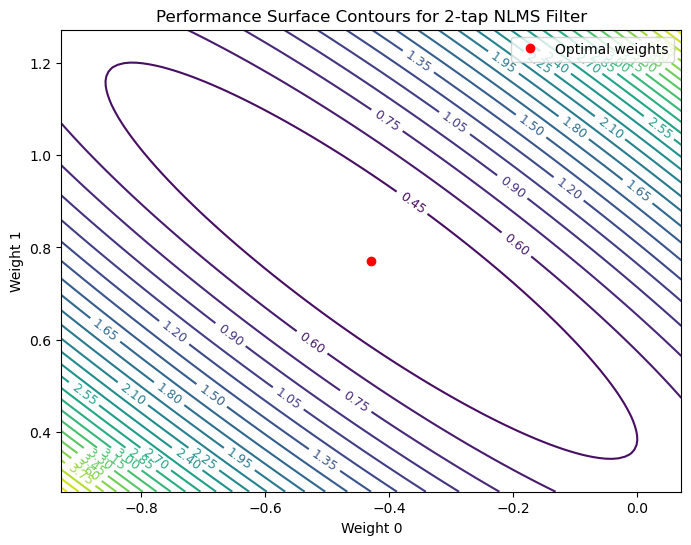

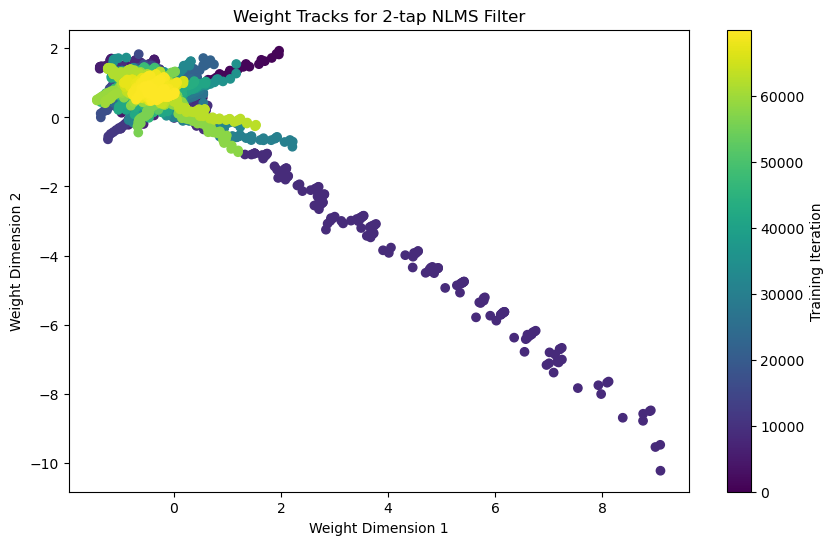

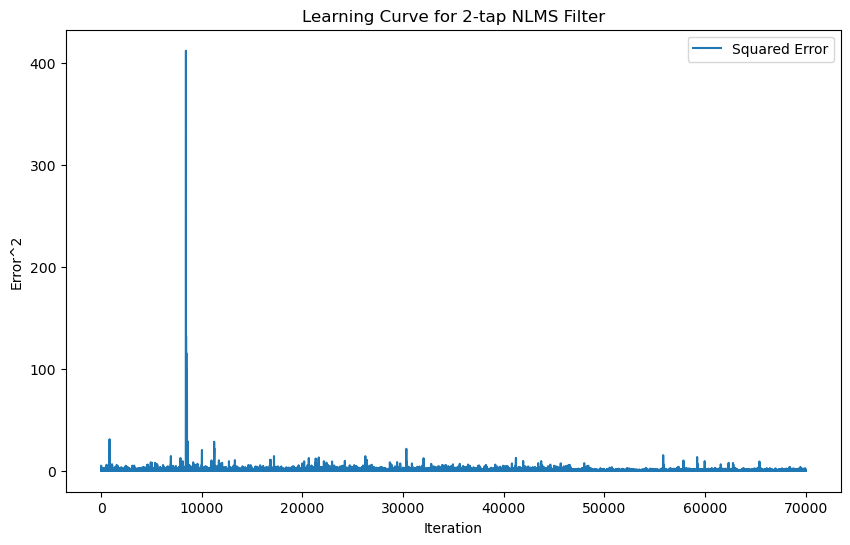

Final Mean Squared Error: 0.0071484532334399635


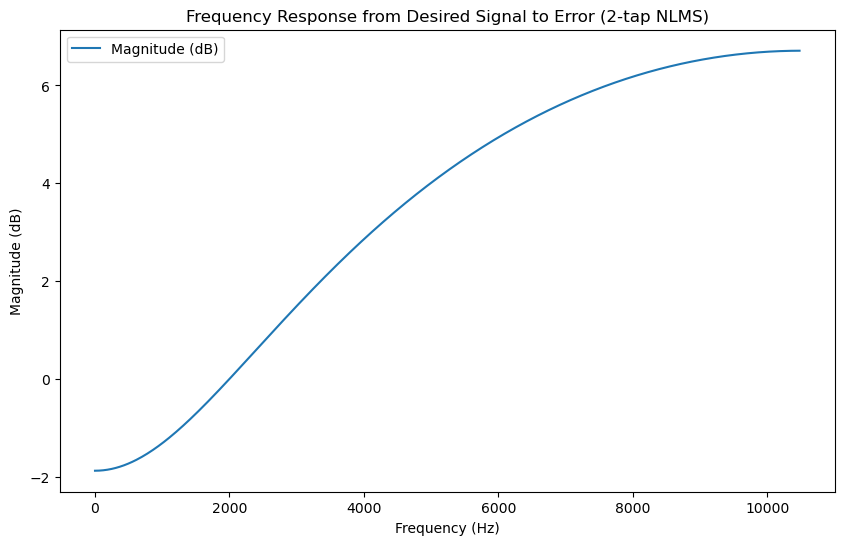

ERLE (SNR improvement): 3.33 dB


In [8]:
mu = 2**-4

experiment_performance_surface_2tap(x, d)
experiment_weight_tracks_2tap(x, d, mu)
experiment_learning_curve_2tap(x, d, mu)
experiment_frequency_response_2tap(x, d, mu, fs=21000)
experiment_erle_improvement_2tap(x, d, mu)

#### M-Tap Filer Inspection

##### Experiment Helper Functions

In [9]:
# 1. Frequency Response from Desired Signal to Error
def experiment_frequency_response_M_order(x, d, mu, M, fs=21000):
    """
    Runs the NLMS filter with an M-order filter and estimates the frequency response
    from the desired signal to the error.
    
    Parameters:
      x  : 1D numpy array, input signal.
      d  : 1D numpy array, desired signal.
      mu : Step size for the NLMS algorithm.
      M  : Filter order.
      fs : Sampling frequency (default 21000 Hz).
    """
    # Run NLMS adaptation (using your provided nlms_filter_full function)
    w_hist, y_hat, mu_eff_hist, e_hist = nlms_filter_full(x, d, M, mu)
    # Use the final filter weights as the estimated system response.
    w_final = w_hist[-1]
    
    # Compute the frequency response of the estimated filter.
    freq, H = freqz(w_final, worN=512, fs=fs)
    # The frequency response from d to error is approximated as 1 - H(f)
    H_de = 1 - H
    
    plt.figure(figsize=(8, 4))
    plt.plot(freq, 20 * np.log10(np.abs(H_de)))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title("Frequency Response from Desired Signal to Error")
    plt.grid(True)
    plt.show()

# 2. SNR Improvement (ERLE) and Discussion
def experiment_snr_improvement_M_order(x, d, mu, M):
    """
    Runs the NLMS filter with an M-order filter and computes the SNR improvement
    (ERLE) defined as 10*log10(E{d^2}/E{e^2}).
    
    Parameters:
      x  : 1D numpy array, input signal.
      d  : 1D numpy array, desired signal.
      mu : Step size for NLMS.
      M  : Filter order.
    """
    w_hist, y_hat, mu_eff_hist, e_hist = nlms_filter_full(x, d, M, mu)
    power_d = np.mean(d**2)
    power_e = np.mean(e_hist**2)
    erle = 10 * np.log10(power_d / power_e)
    
    print(f"ERLE (SNR Improvement): {erle:.2f} dB")
    print("\nNote: ERLE (Echo Return Loss Enhancement) measures the ratio of the desired "
          "signal power to the error power. It is very useful in echo cancellation tasks. "
          "However, in other contexts it might not capture perceptual quality or transient behavior "
          "and so should be complemented with additional performance measures.")

# 3. Evaluate Filter Performance as a Function of Step Size
def experiment_stepsize_performance(x, d, M, mu_candidates):
    """
    Evaluates the filter performance (using final mean-squared error as a proxy) for an M-order filter
    as a function of the step size.
    
    Parameters:
      x             : 1D numpy array, input signal.
      d             : 1D numpy array, desired signal.
      M             : Filter order.
      mu_candidates : List or array of candidate step sizes.
    """
    final_mses = []
    for mu in mu_candidates:
        # Run NLMS adaptation
        w_hist, y_hat, mu_eff_hist, e_hist = nlms_filter_full(x, d, M, mu)
        # Estimate the steady-state MSE using the last 100 samples.
        mse_final = np.mean(e_hist[-100:]**2)
        final_mses.append(mse_final)
        print(f"mu: {mu:.5f}, Final MSE: {mse_final:.6f}")
    
    plt.figure(figsize=(8, 4))
    plt.plot(mu_candidates, final_mses, marker='o')
    plt.xlabel("Step Size (mu)")
    plt.ylabel("Final Mean Squared Error")
    plt.title(f"Filter Performance vs. Step Size (M = {M})")
    plt.xscale('log')
    plt.grid(True)
    plt.show()

# 4. Estimate Misadjustment and Listen/See the Cleaned Signal
def experiment_misadjustment_and_cleaned_signal(x, d, mu, M, fs=21000, save_audio=False, audio_filename="cleaned_signal.wav"):
    """
    Runs the NLMS filter with an M-order filter, estimates the misadjustment, and
    plots (and optionally saves) the cleaned signal (error signal) so that the underlying
    message can be inspected perceptually.
    
    The misadjustment is estimated by comparing the steady-state MSE with the minimum
    achievable MSE (from the Wiener solution).
    
    Parameters:
      x            : 1D numpy array, input signal.
      d            : 1D numpy array, desired signal.
      mu           : Step size for NLMS.
      M            : Filter order.
      fs           : Sampling frequency (default 21000 Hz).
      save_audio   : Boolean flag to save the cleaned signal as an audio file.
      audio_filename: Filename for the saved audio (if save_audio is True).
    """
    # Run NLMS adaptation
    w_hist, y_hat, mu_eff_hist, e_hist = nlms_filter_full(x, d, M, mu)
    final_mse = np.mean(e_hist[-100:]**2)
    
    # Compute the optimal (Wiener) solution for the given data.
    N = len(x)
    x_eff = np.pad(x, (M-1, 0), mode='constant')
    X = np.array([x_eff[i:i+M] for i in range(N)])
    w_opt, _, _, _ = np.linalg.lstsq(X, d, rcond=None)
    d_opt = np.dot(X, w_opt)
    mse_opt = np.mean((d - d_opt)**2)
    
    misadjustment = (final_mse - mse_opt) / mse_opt
    print(f"Final MSE from NLMS: {final_mse:.6f}")
    print(f"Optimal (Wiener) MSE: {mse_opt:.6f}")
    print(f"Estimated Misadjustment: {misadjustment*100:.2f}%")
    
    # Plot the cleaned signal (here, the error signal)
    plt.figure(figsize=(10, 4))
    plt.plot(e_hist, label="Cleaned Signal (Error)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.title("Cleaned Signal after NLMS Adaptation")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Optionally, save the cleaned signal as an audio file for listening.
    if save_audio:
        import soundfile as sf
        sf.write(audio_filename, e_hist, fs)
        print(f"Cleaned signal saved as {audio_filename}")

# 5. Commentary on Convergence in Non-Stationary Environments
def comment_convergence_nonstationary():
    """
    Prints a commentary on the experimental results and addresses issues related to
    the convergence of the NLMS algorithm in non-stationary environments.
    """
    comment = (
        "The experiments show that the NLMS filter performance is highly dependent on the chosen step size.\n"
        "A larger step size typically yields faster convergence but may lead to higher misadjustment, while a smaller step size\n"
        "results in slower convergence with potentially lower steady-state error.\n\n"
        "The ERLE metric (SNR improvement) provides a useful quantitative measure in echo cancellation tasks,\n"
        "but it might not fully capture perceptual quality or transient behavior. In non-stationary environments, where\n"
        "signal statistics evolve over time, the NLMS algorithm may struggle to maintain convergence, resulting in fluctuations\n"
        "in both the weight estimates and the error signal. In such cases, employing a variable step-size strategy or adaptive\n"
        "regularization can improve tracking performance. It is also important to consider other performance metrics—such as\n"
        "perceptual quality and convergence speed—to obtain a more comprehensive evaluation of the filter's behavior."
    )
    print(comment)


##### Experiments

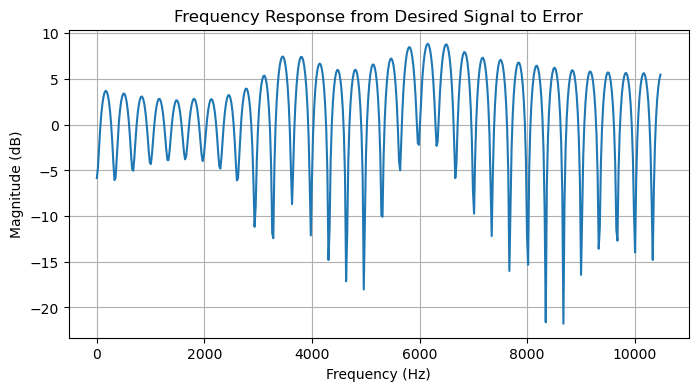

ERLE (SNR Improvement): 13.34 dB

Note: ERLE (Echo Return Loss Enhancement) measures the ratio of the desired signal power to the error power. It is very useful in echo cancellation tasks. However, in other contexts it might not capture perceptual quality or transient behavior and so should be complemented with additional performance measures.
mu: 0.00391, Final MSE: 0.167306
mu: 0.00552, Final MSE: 0.131373
mu: 0.00781, Final MSE: 0.098612
mu: 0.01105, Final MSE: 0.070260
mu: 0.01562, Final MSE: 0.047097


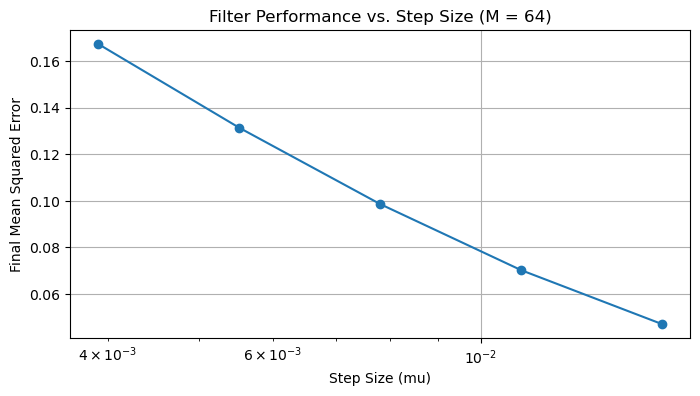

Final MSE from NLMS: 0.005798
Optimal (Wiener) MSE: 0.032196
Estimated Misadjustment: -81.99%


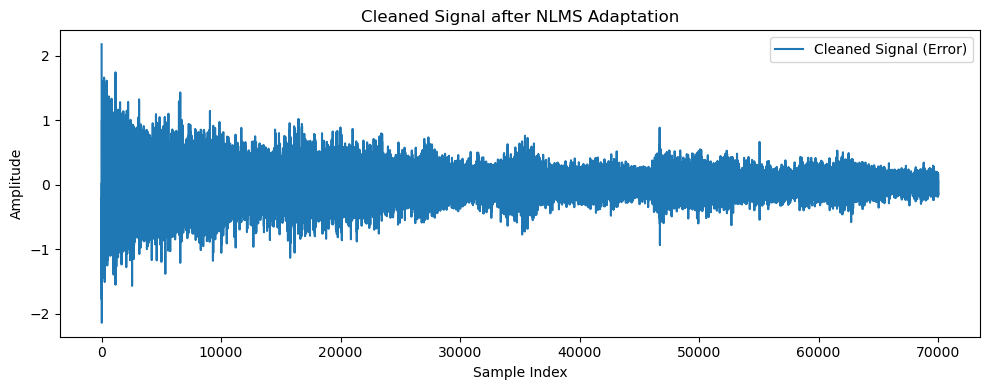

Cleaned signal saved as cleaned_signal.wav
The experiments show that the NLMS filter performance is highly dependent on the chosen step size.
A larger step size typically yields faster convergence but may lead to higher misadjustment, while a smaller step size
results in slower convergence with potentially lower steady-state error.

The ERLE metric (SNR improvement) provides a useful quantitative measure in echo cancellation tasks,
but it might not fully capture perceptual quality or transient behavior. In non-stationary environments, where
signal statistics evolve over time, the NLMS algorithm may struggle to maintain convergence, resulting in fluctuations
in both the weight estimates and the error signal. In such cases, employing a variable step-size strategy or adaptive
regularization can improve tracking performance. It is also important to consider other performance metrics—such as
perceptual quality and convergence speed—to obtain a more comprehensive evaluation of the filter's b

In [10]:
M = 64
# 1. Frequency response estimation
experiment_frequency_response_M_order(x, d, mu, M, fs)

# 2. SNR improvement and ERLE discussion
experiment_snr_improvement_M_order(x, d, mu, M)

# 3. Performance versus step size (try a range of step sizes)
mu_candidates = [2**-8, 2**-7.5, 2**-7, 2**-6.5, 2**-6]
experiment_stepsize_performance(x, d, M, mu_candidates)

# 4. Misadjustment estimation and output the cleaned signal (set save_audio=True to write an audio file)
experiment_misadjustment_and_cleaned_signal(x, d, mu, M, fs, save_audio=True)

# 5. Print commentary on convergence issues in non-stationary environments
comment_convergence_nonstationary()


### Treatment 2

$$
    x_1 = F_1(N) \\
    x_2 = F_2(S + N) \\
    y_i = G(x_i) = g w^T x_i \\
    d = y_2 \\
    e = d - y_1 = G(F_2(S + N)) - G(F_1(N))
$$

For $( F_1(\cdot) \approx F_2(\cdot) )$, we approximate:

$$
    e = G(F(S + N)) - G(F(N))
$$

Assuming that $( G )$ is a nonzero mapping function, then ideally:

$$
    e \approx S \quad \Rightarrow \quad G(\cdot) \approx F^{-1}(\cdot)
$$

In the LMS framework, we define the cost function:

$$
    J = \mathbb{E} [e^2] \approx e_k^2
$$

To ensure that $( G(\cdot) \neq 0 )$, we introduce a constraint on $( w )$:

$$
    e_k = g_k w_k^T (x_2 - x_1) \\
    J = e_k^2 + \lambda (w_k^T w_k - 1)
$$

Minimizing $( J )$ with respect to $( w )$:

$$
    \min_{w_k} J \quad \Rightarrow \quad w_{k+1} = w_k - \mu \nabla_{w_k} J
$$

The gradient can be represented:

$$
    \nabla_{w_k} J = 2 e_k g_k (x_2 - x_1) + 2 \lambda w_k \\
    \nabla_{g_k} J = 2 \frac{e_k^2}{g_k}\\
$$

Applying the LMS weight update:

$$
    w_{k+1} = w_k - \mu (2 e_k g_k (x_2 - x_1) + 2 \lambda w_k ) \\
    = (1 - 2 \mu \lambda) w_k + 2 \mu e_k g_k (x_2 - x_1)
$$

For simplicity, we can write:

$$
    w_{k+1} = (1 - \mu \lambda) w_k + \mu e_k g_k (x_2 - x_1) \\
    g_{k+1} = g_{k} - \mu \frac{e_k^2}{g_k}
$$

## Variable Step Size -Affine Projection Algorithm

#### M-Tap Filter

##### Experiment Helper Functions

In [11]:
def experiment_frequency_response_vss_apa(x, d, M, P, mu0, delta, mu_min, mu_max, rho, eta,
                                            alpha=0.9, beta=0.8, fs=21000, num_predictions=None):
    """
    Experiment 1:
    Estimate the frequency response from the desired signal to the error using the VSS‐APA algorithm.
    
    The final weight vector is used to compute its frequency response, and the mapping from
    d (desired) to e (error) is approximated as 1 – H(f), where H(f) is the filter's response.
    
    Parameters:
      x, d         : Input and desired signals.
      M, P         : Filter order and projection order.
      mu0, delta   : Initial step size and regularization parameter.
      mu_min, mu_max: Lower and upper bounds on the step size.
      rho, eta     : Adaptation rate and target error energy.
      alpha, beta  : Smoothing and momentum factors for step-size adaptation.
      fs           : Sampling frequency.
      num_predictions: Number of iterations to run (if None, run over all available samples).
    """
    predictions, weight_history, mu_history, error_history = vss_apa_filter_full(
        x, d, M, P, mu0, delta, mu_min, mu_max, rho, eta,
        alpha=alpha, beta=beta, num_predictions=num_predictions)
    
    # Use the final weight vector for frequency response estimation.
    w_final = weight_history[-1]
    freq, H = freqz(w_final, worN=512, fs=fs)
    H_de = 1 - H  # Approximate mapping from desired to error
    
    plt.figure(figsize=(8, 4))
    plt.plot(freq, 20 * np.log10(np.abs(H_de)))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title("Frequency Response from Desired Signal to Error (VSS-APA)")
    plt.grid(True)
    plt.show()

def experiment_snr_improvement_vss_apa(x, d, M, P, mu0, delta, mu_min, mu_max, rho, eta,
                                       alpha=0.9, beta=0.8, num_predictions=None):
    """
    Experiment 2:
    Compute the SNR improvement (ERLE) using VSS‐APA.
    
    ERLE is defined as 10*log10( E{d^2} / E{e^2} ), where e is the error signal.
    This metric is useful in echo cancellation, although it may not capture perceptual quality fully.
    
    Parameters:
      x, d         : Input and desired signals.
      M, P         : Filter and projection orders.
      mu0, delta   : Initial step size and regularization parameter.
      mu_min, mu_max: Step size limits.
      rho, eta     : Adaptation rate and target error energy.
      alpha, beta  : Smoothing and momentum factors.
      num_predictions: Number of iterations to run.
    
    Returns:
      erle         : The computed ERLE in dB.
    """
    predictions, weight_history, mu_history, error_history = vss_apa_filter_full(
        x, d, M, P, mu0, delta, mu_min, mu_max, rho, eta,
        alpha=alpha, beta=beta, num_predictions=num_predictions)
    
    start_index = M + P - 1
    d_valid = d[start_index: start_index + len(predictions)]
    errors = d_valid - predictions  # Prediction error for each sample
    power_d = np.mean(d_valid**2)
    power_e = np.mean(errors**2)
    erle = 10 * np.log10(power_d / power_e)
    
    print("ERLE (SNR Improvement): {:.2f} dB".format(erle))
    print("\nNote: ERLE is an important metric in echo cancellation, but it may not fully reflect perceptual quality.")
    return erle

def experiment_stepsize_performance_vss_apa(x, d, M, P, mu0_candidates, delta, mu_min, mu_max, rho, eta,
                                            alpha=0.9, beta=0.8, num_predictions=None):
    """
    Experiment 3:
    Evaluate the filter performance as a function of the initial step size (mu0) using VSS‐APA.
    
    For each candidate mu0, the algorithm is run and the final mean squared error (MSE)
    (averaged over the last 100 iterations) is computed.
    
    Parameters:
      x, d         : Input and desired signals.
      M, P         : Filter and projection orders.
      mu0_candidates: List of candidate initial step sizes.
      delta        : Regularization parameter.
      mu_min, mu_max: Allowed step size range.
      rho, eta     : Adaptation rate and target error energy.
      alpha, beta  : Smoothing and momentum factors.
      num_predictions: Number of iterations to run.
    """
    final_mses = []
    for mu0 in mu0_candidates:
        predictions, weight_history, mu_history, error_history = vss_apa_filter_full(
            x, d, M, P, mu0, delta, mu_min, mu_max, rho, eta,
            alpha=alpha, beta=beta, num_predictions=num_predictions)
        # Use the error corresponding to the current sample (first element of each error vector)
        errors = error_history[:, 0]
        if len(errors) >= 100:
            mse = np.mean(errors[-100:]**2)
        else:
            mse = np.mean(errors**2)
        final_mses.append(mse)
        print("Initial mu0: {:.5f}, Final MSE: {:.6f}".format(mu0, mse))
    
    plt.figure(figsize=(8, 4))
    plt.plot(mu0_candidates, final_mses, marker='o')
    plt.xlabel("Initial Step Size (mu0)")
    plt.ylabel("Final Mean Squared Error")
    plt.title("Filter Performance vs. Initial Step Size (VSS-APA, M={}, P={})".format(M, P))
    plt.xscale('log')
    plt.grid(True)
    plt.show()

def experiment_misadjustment_and_cleaned_signal_vss_apa(x, d, M, P, mu0, delta, mu_min, mu_max, rho, eta,
                                                        alpha=0.9, beta=0.8, fs=21000, save_audio=False,
                                                        audio_filename="vss_apa_cleaned.wav", num_predictions=None):
    """
    Experiment 4:
    Estimate the misadjustment and analyze the cleaned signal (error) using VSS‐APA.
    
    The misadjustment is computed by comparing the final MSE with the optimal (Wiener) MSE
    computed on the valid data segment. The cleaned signal is then plotted and can be saved as audio.
    
    Parameters:
      x, d         : Input and desired signals.
      M, P         : Filter and projection orders.
      mu0, delta   : Initial step size and regularization parameter.
      mu_min, mu_max: Step size bounds.
      rho, eta     : Adaptation rate and target error energy.
      alpha, beta  : Smoothing and momentum factors.
      fs           : Sampling frequency.
      save_audio   : Flag to save the cleaned signal as an audio file.
      audio_filename: Filename for the saved audio.
      num_predictions: Number of iterations to run.
    """
    predictions, weight_history, mu_history, error_history = vss_apa_filter_full(
        x, d, M, P, mu0, delta, mu_min, mu_max, rho, eta,
        alpha=alpha, beta=beta, num_predictions=num_predictions)
    
    # Use the error corresponding to the current sample (first element of each error vector)
    errors = error_history[:, 0]
    if len(errors) >= 100:
        final_mse = np.mean(errors[-100:]**2)
    else:
        final_mse = np.mean(errors**2)
    
    # Compute the optimal Wiener solution for the valid segment.
    start_index = M + P - 1
    N_valid = len(predictions)
    x_eff = np.pad(x, (M-1, 0), mode='constant')
    X_valid = np.array([x_eff[i:i+M] for i in range(start_index, start_index + N_valid)])
    d_valid = d[start_index: start_index + N_valid]
    w_opt, _, _, _ = np.linalg.lstsq(X_valid, d_valid, rcond=None)
    d_opt = np.dot(X_valid, w_opt)
    mse_opt = np.mean((d_valid - d_opt)**2)
    
    misadjustment = (final_mse - mse_opt) / mse_opt
    print("Final MSE from VSS-APA: {:.6f}".format(final_mse))
    print("Optimal (Wiener) MSE: {:.6f}".format(mse_opt))
    print("Estimated Misadjustment: {:.2f}%".format(misadjustment * 100))
    
    plt.figure(figsize=(10, 4))
    plt.plot(errors, label="Cleaned Signal (Error)")
    plt.xlabel("Iteration")
    plt.ylabel("Error Amplitude")
    plt.title("Cleaned Signal after VSS-APA Adaptation")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    if save_audio:
        sf.write(audio_filename, errors, fs)
        print("Cleaned signal saved as {}".format(audio_filename))

def comment_convergence_nonstationary_vss_apa():
    """
    Experiment 5:
    Provide a commentary on the experimental results and address convergence issues in non-stationary environments.
    
    This commentary highlights that while the variable step-size mechanism (with exponential smoothing and momentum)
    helps in tracking time-varying signals, proper parameter tuning is crucial. Metrics such as ERLE and misadjustment,
    while useful, may not capture perceptual quality fully.
    """
    comment = (
        "The VSS-APA algorithm adapts its step size using both error energy smoothing (α) and a momentum term (β), "
        "which improves its tracking ability in non-stationary environments. However, the performance remains highly sensitive "
        "to the choice of parameters (mu0, rho, eta, α, β). While ERLE is a useful metric in echo cancellation tasks, it may not "
        "fully reflect perceptual improvements in other applications. In non-stationary environments, rapid changes in signal "
        "statistics can lead to fluctuations in the weight estimates and error signal, underscoring the need for robust adaptation "
        "mechanisms and additional performance metrics (both quantitative and perceptual) for a comprehensive evaluation."
    )
    print(comment)


##### Experiments

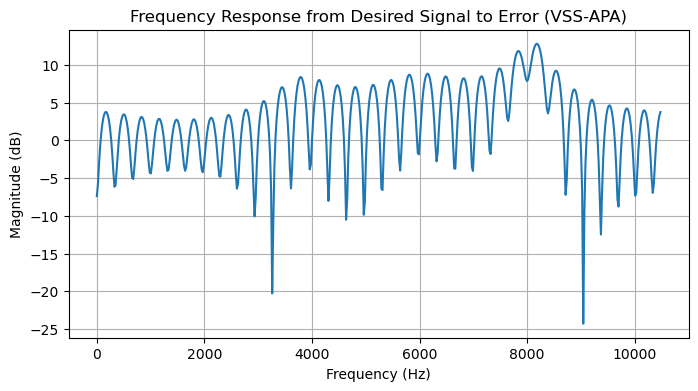

ERLE (SNR Improvement): 14.63 dB

Note: ERLE is an important metric in echo cancellation, but it may not fully reflect perceptual quality.
Initial mu0: 0.05000, Final MSE: 0.000059
Initial mu0: 0.10000, Final MSE: 0.000059
Initial mu0: 0.20000, Final MSE: 0.000059
Initial mu0: 0.50000, Final MSE: 0.000059


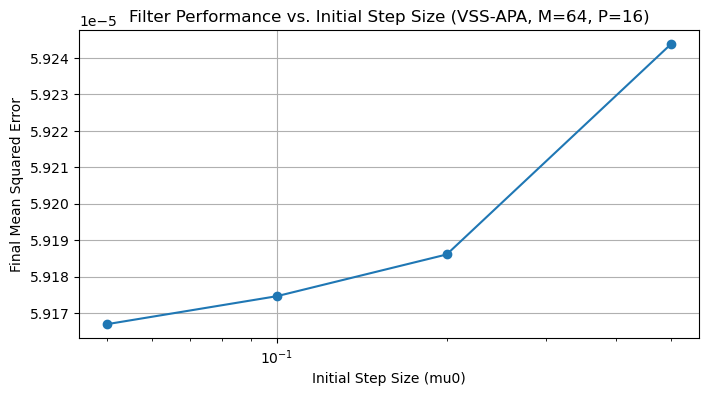

Final MSE from VSS-APA: 0.000059
Optimal (Wiener) MSE: 0.032217
Estimated Misadjustment: -99.82%


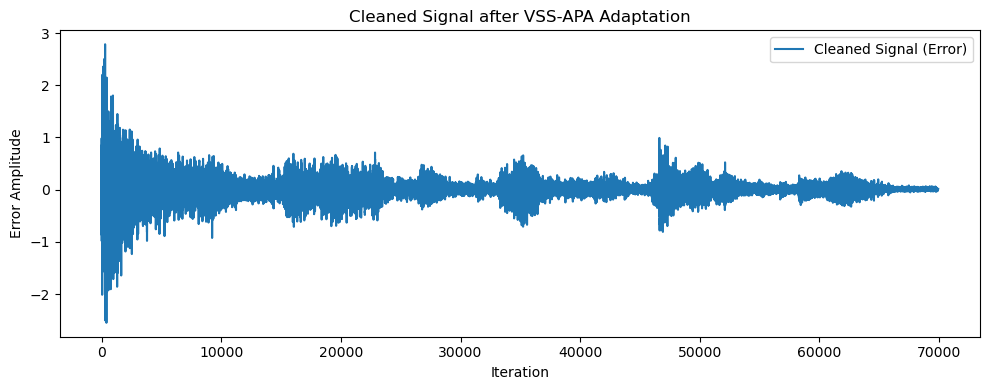

Cleaned signal saved as vss_apa_cleaned.wav
The VSS-APA algorithm adapts its step size using both error energy smoothing (α) and a momentum term (β), which improves its tracking ability in non-stationary environments. However, the performance remains highly sensitive to the choice of parameters (mu0, rho, eta, α, β). While ERLE is a useful metric in echo cancellation tasks, it may not fully reflect perceptual improvements in other applications. In non-stationary environments, rapid changes in signal statistics can lead to fluctuations in the weight estimates and error signal, underscoring the need for robust adaptation mechanisms and additional performance metrics (both quantitative and perceptual) for a comprehensive evaluation.


In [13]:
M = 64           # Filter order
P = 16            # Projection order
mu0 = 0.1        # Initial step size
delta = 1e-3     # Regularization parameter
mu_min = 0.001   # Minimum allowed step size
mu_max = 1.0     # Maximum allowed step size
rho = 0.001      # Adaptation rate for the step size
eta = 0.001      # Target error energy threshold
alpha = 0.95      # Exponential smoothing factor for error energy
beta = 0.8       # Momentum factor for step-size adaptation

# Experiment 1: Frequency Response
experiment_frequency_response_vss_apa(x, d, M, P, mu0, delta, mu_min, mu_max, rho, eta, alpha=alpha, beta=beta, fs=21000)

# Experiment 2: SNR Improvement (ERLE)
experiment_snr_improvement_vss_apa(x, d, M, P, mu0, delta, mu_min, mu_max, rho, eta, alpha=alpha, beta=beta,)

# Experiment 3: Performance vs. Initial Step Size
mu0_candidates = [0.05, 0.1, 0.2, 0.5]
experiment_stepsize_performance_vss_apa(x, d, M, P, mu0_candidates, delta, mu_min, mu_max, rho, eta, alpha=alpha, beta=beta,)

# Experiment 4: Misadjustment and Cleaned Signal
experiment_misadjustment_and_cleaned_signal_vss_apa(x, d, M, P, mu0, delta, mu_min, mu_max, rho, eta, alpha=alpha, beta=beta, fs=21000, save_audio=True)

# Experiment 5: Commentary on Convergence in Non-Stationary Environments
comment_convergence_nonstationary_vss_apa()
